# **CS5658 Anomaly Detection Homework3 – Industrial Anomaly Detection**

## Due Date:  5/2 23:30

#### MVTec AD dataset
MVTec AD is a benchmark dataset for industrial anomaly detection tasks. It contains 15 industrial product classes with over 5000 images in total. The dataset is designed to perform image anomaly detection and segmentation tasks. There are normal / defect images for each class, with ground truth masks provided for the defect samples.


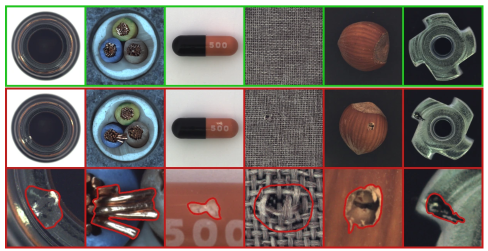

###SimpleNet
SimpleNet is a deep learning model proposed in CVPR 2023. It trains a simple MLP by classifying noisy features from normal features and using it as a discriminator to classify whether a feature is anomaly or not.

Reference: SimpleNet, CVPR 2023

Paper: https://openaccess.thecvf.com/content/CVPR2023/papers/Liu_SimpleNet_A_Simple_Network_for_Image_Anomaly_Detection_and_Localization_CVPR_2023_paper.pdf

Github: https://github.com/DonaldRR/SimpleNet

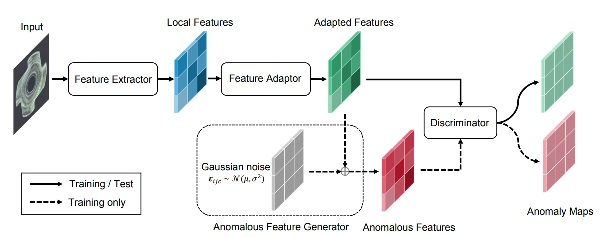


# Problem Setting
In this homework, we will choose two classes in MVTecAD: `metal_nut` and `leather` to perform anomaly detection and segmentation task. You need to implement SimpleNet method by your own, then inference on the two classes. We will use SimpleNet as our architecture, but for the simplicity and training speed, we've made a little adjustments.

* Ignore average pooling in constructing multi-scale feature map
* Use layers [2,3] of WideResNet50
* Epoch reduced from 40 to 20
* Ignore learning rate scheduler
* Discriminator outputs anomaly score instead of normal score

Please implement adaptor and discriminator using the assigned learning rate as follow.
```
adaptor_lr = 1e-3
discriminator_lr = 2e-4
```

Please use **pretrained WideResNet 50** as your feature extractor.

# 1.Download Dataset

In [ ]:
!gdown 1vFb_AWIK6nh8BRhRQLM96q2nUqPHsdAR
!unzip mvtec.zip

# 2.Prepare Environment

1.Install needed modules

In [2]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 914.7 kB/s eta 0:00:00


2.Import needed modules and set random seed to ensure that results
are consistent every time executed.

In [3]:
from torchvision.models import wide_resnet50_2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
from einops import rearrange
from tqdm.notebook import tqdm
import os
from sklearn.preprocessing import minmax_scale


#########################################
# prepare environment
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

seed_everything(9999)

# 3.Prepare Dataset

In [4]:
#######################################
# prepare dataset
class MVTecDataset(Dataset):
    def __init__(self, mvtec_folder_path='./mvtec', class_name='leather', is_train=True,
                 few_shot=16,resize=256):
        self.class_name = class_name
        self.is_train = is_train
        self.resize = resize
        self.mvtec_folder_path = mvtec_folder_path
        self.few_shot = few_shot
        # set transforms
        self.transform_x = T.Compose([T.Resize(resize,interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize(resize, interpolation=T.InterpolationMode.NEAREST),
                                         T.ToTensor()])
        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()
        phase = 'training' if self.is_train else 'testing'
        print(f"{self.class_name} {phase} dataset created, consists of {len(self.x)} images")


    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []
        img_dir = os.path.join(self.mvtec_folder_path, self.class_name, phase)
        gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')
        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types:
            # load images
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue
            img_fpath_list = sorted([os.path.join(img_type_dir, f)
                                     for f in os.listdir(img_type_dir)
                                     if f.endswith('.png')])
            x.extend(img_fpath_list)
            # load gt labels
            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png')
                                 for img_fname in img_fname_list]
                mask.extend(gt_fpath_list)

        assert len(x) == len(y), 'number of x and y should be same'

        if self.few_shot is not None and phase=='train':
            # pick images according to few_shot number
            chosen_idx = random.sample(list(range(len(x))),k=self.few_shot)
            x = [x[i] for i in chosen_idx]
            y = [y[i] for i in chosen_idx]
            mask = [mask[i] for i in chosen_idx]

        return [self.transform_x(Image.open(x).convert('RGB')).cuda() for x in list(x)], \
                list(y), \
                [torch.zeros([1, self.resize, self.resize]).cuda() if y==0 else self.transform_mask(Image.open(mask)).cuda() for y,mask in zip(list(y),list(mask))]


# 4.Load & Prepare Feature Extractor

In [5]:

#######################################
# load & prepare model (wide_resnet50_2)
encoder = wide_resnet50_2(pretrained=True, progress=True).cuda()
encoder.eval()
# set hook function to get features
outputs = list()
def hook(module, input, output):
    outputs.append(output)

def get_features(model,img,outputs):
    with torch.no_grad():
            _ = model(img.cuda())
    layer1_feature = outputs[0]
    layer2_feature = outputs[1]
    layer3_feature = outputs[2]
    outputs.clear()
    return [layer1_feature,layer2_feature,layer3_feature]

encoder.layer1.register_forward_hook(hook)
encoder.layer2.register_forward_hook(hook)
encoder.layer3.register_forward_hook(hook)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 152MB/s]


# 5.Define Our Function to Produce Multi-Scale Feature Map (TODO Q1)

## TODO Q1
In this section, you need to produce multi-scale feature map in this function.</br></br>
The procedure is listed below:</br>
1. Choose a size to resize to, for example, size of second layers as our target size.</br>
1. Resize all features to the target size and store them.</br>
1. Concatenate them all together and return the result.</br>

You need to finish the step2 above, that is, resize `features[i]` to the target size and assign to `temp_feature`.</br>
For example, if the `target_size` is 32, and `features[i]` have size `(batch, channel, width, height)`, the `temp_feature` should have size `(batch, channel, 32, 32)`




In [6]:
import torch.nn.functional as F
#######################################
# produce multi-scale feature
def concat_feature(features,use_layers=None):
    use_layers = [i-1 for i in use_layers]
    # determine resize to which feature
    target_size = features[1].size()[3] # 32
    resized_feature = list()

    for i in range(len(features)):
        current_size = features[i].size()[3]
        ## TODO ######################################################
        # please calculate the factor or size to resize to
        # use F.interpolate() to resize, set mode to bilinear
        # align_corners to False.
        # For more instruction, please refer to :
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
        temp_feaure = F.interpolate(input=features[i],size=target_size,mode='bilinear',align_corners=False)
        #############################################################
        resized_feature.append(temp_feaure)
    return torch.concat([resized_feature[i] for i in use_layers],dim=1)

# 6.Define The Adaptor & Discriminator Of Our Model (TODO Q2)

## TODO Q2
- In this section, you need to design a MLP as the Adaptor.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `out_channel` as its channel dimention.</br>
- Implement **the same Adaptor** in SimpleNet paper.
NOTE: the MLP should not be very complex, you can design a simple one, check the result, and determine if it needs to be more complex. </br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. your image-AUC of both classes must be greater than 0.8.</br>
***layers = Linear -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension, add Dropout layer, etc. </br>

In [7]:
# Implement the same Adaptor in SimpleNet
def init_weight(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
    elif isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
class Adaptor(torch.nn.Module):
    def __init__(self, in_channel, out_channel=None, n_layers=1):
        super(Adaptor, self).__init__()
        if out_channel is None:
            out_channel = in_channel
        self.layers = torch.nn.Sequential()
        _in = None
        _out = None
        for i in range(n_layers):
            _in = in_channel if i == 0 else out_channel
            _out = out_channel
            self.layers.add_module(f"fc{i}",torch.nn.Linear(in_channel, out_channel))
            if i < n_layers - 1:
              self.layers.add_module(f"relu{i}",torch.nn.LeakyReLU(0.2))
        self.apply(init_weight)
    def forward(self, x):
        x = rearrange(x,'b c h w -> (b h w) c')
        x = self.layers(x)
        return x

- In this section, you need to design a MLP as the Discriminator's body.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `mid_channel` as its channel dimention.</br>
- First, implement **the same Discriminator** in SimpleNet paper.
- Second, design your own version of Discriminator with **fewer model parameters to approach the SimpleNet performance**. You need to try **TWO** kinds of model settings. </br>
NOTE: the Discriminator should involve at least one BatchNormalization layer.</br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. It's OK to get lower score than default, but image-AUC of both classes must be greater than 0.8.</br>
***Body = Linear -> BatchNorm1d -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension (`mid_channel`), add Dropout layer, etc. </br>


In [8]:
# Implement the same Discriminator in SimpleNet
class Discriminator(torch.nn.Module):
    def __init__(self, in_channel, mid_channel=1024, n_layers=2):
        super(Discriminator, self).__init__()
        _hidden = in_channel if mid_channel is None else mid_channel
        self.body = torch.nn.Sequential()
        for i in range(n_layers-1):
            _in = in_channel if i == 0 else _hidden
            _hidden = mid_channel
            self.body.add_module(f'block{i}',torch.nn.Sequential(torch.nn.Linear(_in,_hidden),torch.nn.BatchNorm1d(_hidden),torch.nn.LeakyReLU(0.2)))
        self.tail = torch.nn.Linear(_hidden, 1, bias=False)
        self.apply(init_weight)
    def forward(self,x):
        x = self.body(x)
        x = self.tail(x)
        return x
# Implement your own Discriminator with fewer model parameters
class Discriminator_me_1(torch.nn.Module):
    def __init__(self, in_channel, mid_channel=900, n_layers=2):
        super(Discriminator_me_1, self).__init__()
        _hidden = in_channel if mid_channel is None or n_layers==1 else mid_channel
        self.body = torch.nn.Sequential()
        for i in range(n_layers-1):
            _in = in_channel if i == 0 else _hidden
            _hidden = mid_channel
            self.body.add_module(f'block{i}',torch.nn.Sequential(torch.nn.Linear(_in,_hidden),torch.nn.BatchNorm1d(_hidden),torch.nn.LeakyReLU(0.2)))
        self.tail = torch.nn.Linear(_hidden, 1, bias=False)
        self.apply(init_weight)
    def forward(self,x):
        x = self.body(x)
        x = self.tail(x)
        return x

class Discriminator_me_2(torch.nn.Module):
    def __init__(self, in_channel, mid_channel=800, n_layers=2):
        super(Discriminator_me_2, self).__init__()
        _hidden = in_channel if mid_channel is None or n_layers==1 else mid_channel
        self.body = torch.nn.Sequential()
        for i in range(n_layers-1):
            _in = in_channel if i == 0 else _hidden
            _hidden = mid_channel
            self.body.add_module(f'block{i}',torch.nn.Sequential(torch.nn.Linear(_in,_hidden),torch.nn.BatchNorm1d(_hidden),torch.nn.LeakyReLU(0.2)))
        self.tail = torch.nn.Linear(_hidden, 1, bias=False)
        self.apply(init_weight)
    def forward(self,x):
        x = self.body(x)
        x = self.tail(x)
        return x

# 7.Define Our Whole Model (SimpleNet)

In [9]:
#######################################
# define our model (simplenet)
class Simplenet(nn.Module):
    def __init__(self,in_channel):
        super(Simplenet,self).__init__()
        self.adaptor = Adaptor(in_channel,in_channel)
        self.discriminator = Discriminator(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

# 8.Define The Training Process

In [10]:
def train_one_epoch(encoder,simplenet,adaptor_optim,discriminator_optim,dataset,use_layers,batch_size):
    total_loss = 0
    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        scores = simplenet(features)
        true_scores = scores[:features.size()[0]*features.size()[2]*features.size()[3]]
        fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

        th = 0.5 #margin
        true_loss = torch.clip(true_scores + th, min=0)
        fake_loss = torch.clip(-fake_scores + th, min=0)

        loss = true_loss.mean() + fake_loss.mean()
        total_loss+=loss

        # clear gradient
        adaptor_optim.zero_grad()
        discriminator_optim.zero_grad()

        # calculate new gradient
        loss.backward()

        # update parameters
        adaptor_optim.step()
        discriminator_optim.step()
    return total_loss

# 9.Define The Testing Process

In [11]:
#######################################
# testing
@torch.no_grad()
def test(encoder,simplenet,dataset,use_layers,batch_size):
    result = dict()
    result['total_scores_pixel'] = list()
    result['total_scores_image'] = list()
    result['total_gt_pixel'] = list()
    result['total_gt_image'] = list()
    result['features_orig'] = list()
    result['features_adapted'] = list()
    result['input_image'] = list()


    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        simplenet.eval()
        # store input image
        result['input_image'].append(x.cpu().detach().numpy())
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        # store features before adaptor
        result['features_orig'].append(rearrange(features,'b c h w -> (b h w) c').cpu().detach().numpy())
        size = features.size()
        scores,true_feats = simplenet.predict(features)
        # store features after adaptor
        result['features_adapted'].append(true_feats.cpu().detach().numpy())

        # calculate and store image-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b (h w)',b=size[0],h=size[3],w=size[2])
        image_score,_ = torch.max(anomaly_score_map,dim=1,keepdim=False)
        result['total_scores_image'].append(image_score.cpu().detach().numpy())

        # calculate and store pixel-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b 1 h w',b=size[0],h=size[3],w=size[2])
        anomaly_score_map = F.interpolate(anomaly_score_map,
                                        size=(x.size()[2],x.size()[3]),
                                        mode="bilinear",
                                        align_corners=False)
        anomaly_score_1d = rearrange(anomaly_score_map,'b c h w -> (b c h w)')
        result['total_scores_pixel'].append(anomaly_score_1d.cpu().detach().numpy())

        # store groundtruth
        mask_1d = rearrange(mask,'b c h w -> (b c h w)')
        result['total_gt_pixel'].append(mask_1d.cpu().detach().numpy())
        result['total_gt_image'].append(y.cpu().detach().numpy())

    # gether all scores and groundtruth
    result['input_image'] = np.concatenate(result['input_image'],axis=0)
    result['total_scores_pixel'] = np.hstack(result['total_scores_pixel'])
    result['total_scores_image'] = np.hstack(result['total_scores_image'])
    result['total_gt_pixel'] = np.hstack(result['total_gt_pixel'])
    result['total_gt_image'] = np.hstack(result['total_gt_image'])

    # gether all extracted features
    result['features_orig'] = np.concatenate(result['features_orig'],axis=0)
    result['features_adapted'] = np.concatenate(result['features_adapted'],axis=0)

    # min-max normalization on scores
    result['total_scores_pixel'] = minmax_scale(result['total_scores_pixel'])
    result['total_scores_image'] = minmax_scale(result['total_scores_image'])

    simplenet.train()
    return result

# 10.Define Functions That Calculate And Show ROC & AUROC (TODO Q3)

## TODO Q3
In this section, you need to define the function to calculate false-positive rate, true-positive rate and area-under ROC by the scores and the groundtruth labels and assign them to `fpr`, `tpr`, `auc` respectively.

In [12]:
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
def calculate(scores,labels):
  fpr, tpr, thresholds = roc_curve(labels, scores)
  return fpr, tpr, roc_auc_score(labels, scores)

# 11.Define Other Utility Functions (if Needed)

# 12.Setup Training Parameters

Setup learning rate, total epoch, layers to used, SimpleNet and optimizer for both class.

In [13]:
# Training parameters
adaptor_lr = 1e-3
discriminator_lr = 2e-4
epochs = 20
batch_size = 4
# Define use_layers
use_layers = [2,3]
# Create SimpleNet and optimizer for both classes
SimpleNet_1 = Simplenet(1536).cuda()
SimpleNet_2 = Simplenet(1536).cuda()
optimizer_1_a = torch.optim.AdamW(SimpleNet_1.adaptor.parameters(),adaptor_lr)
optimizer_1_d = torch.optim.AdamW(SimpleNet_1.discriminator.parameters(),discriminator_lr)
optimizer_2_a = torch.optim.AdamW(SimpleNet_2.adaptor.parameters(),adaptor_lr)
optimizer_2_d = torch.optim.AdamW(SimpleNet_2.discriminator.parameters(),discriminator_lr)

In [14]:
# Create datasets for both classes
dataset_1_train = MVTecDataset(class_name='metal_nut',is_train=True)
dataset_1_test = MVTecDataset(class_name='metal_nut',is_train=False)
dataset_2_train = MVTecDataset(class_name='leather',is_train=True)
dataset_2_test = MVTecDataset(class_name='leather',is_train=False)

metal_nut training dataset created, consists of 16 images
metal_nut testing dataset created, consists of 115 images
leather training dataset created, consists of 16 images
leather testing dataset created, consists of 124 images


# 13.Start Training & Testing (TODO Q4)

## TODO Q4
Write your training / testing code and plot ROC curve.

In [15]:
def train_and_test(epochs,encoder,SimpleNet,optimizer_a,optimizer_d,dataset_train,dataset_test,use_layers,batch_size):
  for i in range(epochs):
    train_one_epoch(encoder,SimpleNet,optimizer_a,optimizer_d,dataset_train,use_layers,batch_size)
  return test(encoder,SimpleNet,dataset_test,use_layers,batch_size)

Calculate & Plot ROC curve

In [16]:
def Calculate_Plot_ROC(score,label,dataset,model_name):
  fpr, tpr, auc = calculate(score,label)
  plt.plot(fpr, tpr)
  plt.xlabel("fpr")
  plt.ylabel("tpr")
  plt.title(f"{dataset}:{model_name}")
  return auc

0.9887585532746823


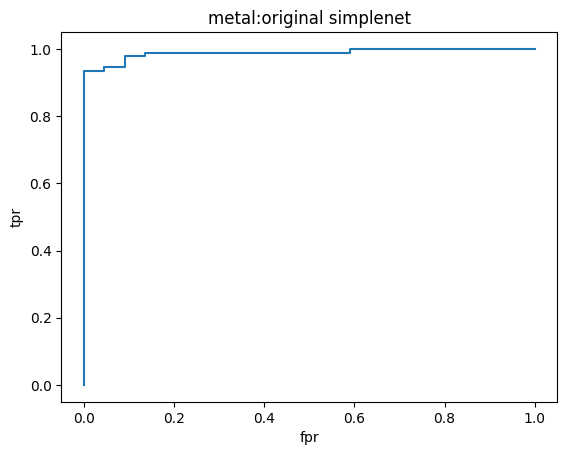

In [17]:
result_1_ori = train_and_test(epochs,encoder,SimpleNet_1,optimizer_1_a,optimizer_1_d,dataset_1_train,dataset_1_test,use_layers,batch_size)
auc_1_o = Calculate_Plot_ROC(result_1_ori['total_scores_image'],result_1_ori['total_gt_image'],"metal","original simplenet")
print(auc_1_o)

1.0


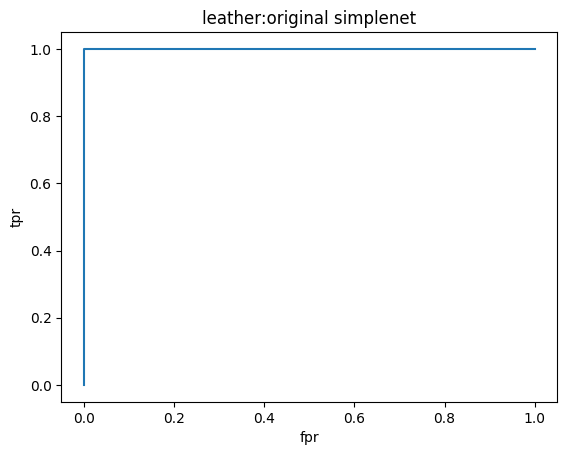

In [18]:
result_2_ori = train_and_test(epochs,encoder,SimpleNet_2,optimizer_2_a,optimizer_2_d,dataset_2_train,dataset_2_test,use_layers,batch_size)
auc_2_o = Calculate_Plot_ROC(result_2_ori['total_scores_image'],result_2_ori['total_gt_image'],"leather","original simplenet")
print(auc_2_o)

# 14.Plot Parameters-ROC Figure (TODO Q5)


## TODO Q5
* Try different number of parameters in Adaptor/Discriminator, record the performance.
* Plot the figure with `X-axis=Number of SimpleNet Params`, `Y-axis=AUROC Performance`
* Mark the original SimpleNet as `black point`.
* Mark your models with different number of parameters as `blue points`.


In [19]:
#######################################
# define our model (simplenet)
class Simplenet_me_1(nn.Module):
    def __init__(self,in_channel):
        super(Simplenet_me_1,self).__init__()
        self.adaptor = Adaptor(in_channel,in_channel)
        self.discriminator = Discriminator_me_1(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

class Simplenet_me_2(nn.Module):
    def __init__(self,in_channel):
        super(Simplenet_me_2,self).__init__()
        self.adaptor = Adaptor(in_channel,in_channel)
        self.discriminator = Discriminator_me_2(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

In [20]:
SimpleNet_1_me_1 = Simplenet_me_1(1536).cuda()
SimpleNet_2_me_1 = Simplenet_me_1(1536).cuda()
optimizer_1_a_me_1 = torch.optim.AdamW(SimpleNet_1_me_1.adaptor.parameters(),adaptor_lr)
optimizer_1_d_me_1 = torch.optim.AdamW(SimpleNet_1_me_1.discriminator.parameters(),discriminator_lr)
optimizer_2_a_me_1 = torch.optim.AdamW(SimpleNet_2_me_1.adaptor.parameters(),adaptor_lr)
optimizer_2_d_me_1 = torch.optim.AdamW(SimpleNet_2_me_1.discriminator.parameters(),discriminator_lr)

In [21]:
SimpleNet_1_me_2 = Simplenet_me_2(1536).cuda()
SimpleNet_2_me_2 = Simplenet_me_2(1536).cuda()
optimizer_1_a_me_2 = torch.optim.AdamW(SimpleNet_1_me_2.adaptor.parameters(),adaptor_lr)
optimizer_1_d_me_2 = torch.optim.AdamW(SimpleNet_1_me_2.discriminator.parameters(),discriminator_lr)
optimizer_2_a_me_2 = torch.optim.AdamW(SimpleNet_2_me_2.adaptor.parameters(),adaptor_lr)
optimizer_2_d_me_2 = torch.optim.AdamW(SimpleNet_2_me_2.discriminator.parameters(),discriminator_lr)

In [22]:
# Use the following code to measure your model parameters
def num_params(model):
  num = sum(p.numel() for p in model.parameters())
  return num

In [23]:
num_o = num_params(SimpleNet_1)

In [24]:
num_1 = num_params(SimpleNet_1_me_1)

In [25]:
num_2 = num_params(SimpleNet_1_me_2)

In [26]:
del optimizer_1_a
del optimizer_1_d
del SimpleNet_1
del optimizer_2_a
del optimizer_2_d
del SimpleNet_2

0.9921798631476051


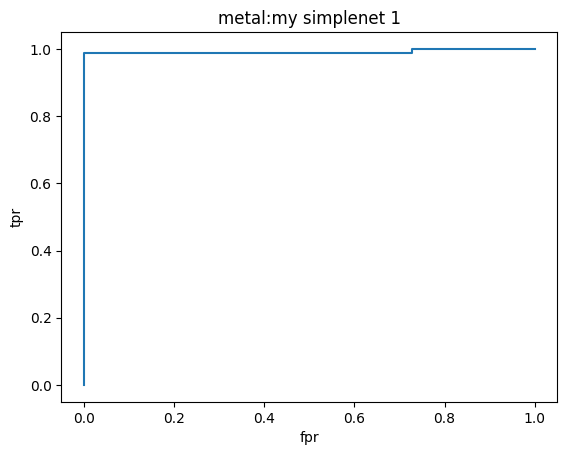

In [27]:
result_1_me_1 = train_and_test(epochs,encoder,SimpleNet_1_me_1,optimizer_1_a_me_1,optimizer_1_d_me_1,dataset_1_train,dataset_1_test,use_layers,batch_size)
auc_1_1 = Calculate_Plot_ROC(result_1_me_1['total_scores_image'],result_1_me_1['total_gt_image'],"metal","my simplenet 1")
print(auc_1_1)
del result_1_me_1
del optimizer_1_a_me_1
del optimizer_1_d_me_1
del SimpleNet_1_me_1

1.0


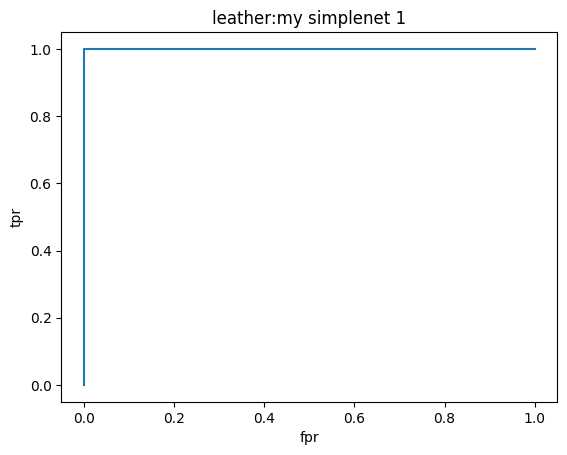

In [28]:
result_2_me_1 = train_and_test(epochs,encoder,SimpleNet_2_me_1,optimizer_2_a_me_1,optimizer_2_d_me_1,dataset_2_train,dataset_2_test,use_layers,batch_size)
auc_2_1 = Calculate_Plot_ROC(result_2_me_1['total_scores_image'],result_2_me_1['total_gt_image'],"leather","my simplenet 1")
print(auc_2_1)
del result_2_me_1
del optimizer_2_a_me_1
del optimizer_2_d_me_1
del SimpleNet_2_me_1

0.9452590420332355


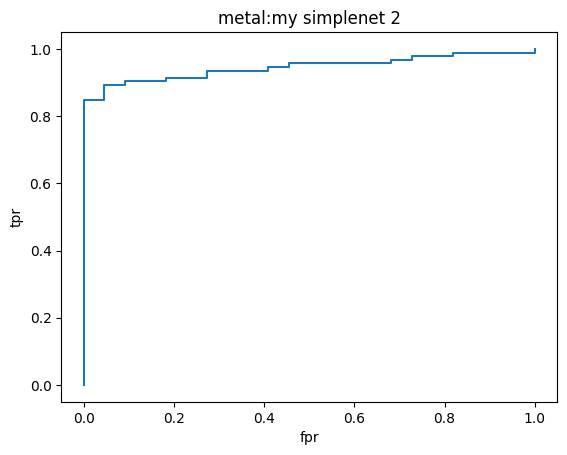

In [29]:
result_1_me_2 = train_and_test(epochs,encoder,SimpleNet_1_me_2,optimizer_1_a_me_2,optimizer_1_d_me_2,dataset_1_train,dataset_1_test,use_layers,batch_size)
auc_1_2 = Calculate_Plot_ROC(result_1_me_2['total_scores_image'],result_1_me_2['total_gt_image'],"metal","my simplenet 2")
print(auc_1_2)
del result_1_me_2
del optimizer_1_a_me_2
del optimizer_1_d_me_2
del SimpleNet_1_me_2

1.0


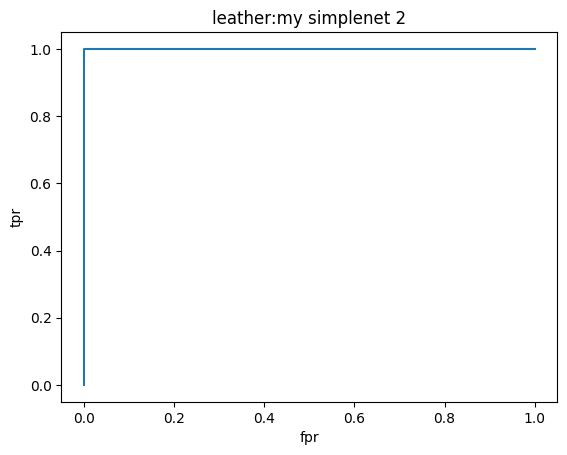

In [30]:
result_2_me_2 = train_and_test(epochs,encoder,SimpleNet_2_me_2,optimizer_2_a_me_2,optimizer_2_d_me_2,dataset_2_train,dataset_2_test,use_layers,batch_size)
auc_2_2 = Calculate_Plot_ROC(result_2_me_2['total_scores_image'],result_2_me_2['total_gt_image'],"leather","my simplenet 2")
print(auc_2_2)
del result_2_me_2
del optimizer_2_a_me_2
del optimizer_2_d_me_2
del SimpleNet_2_me_2

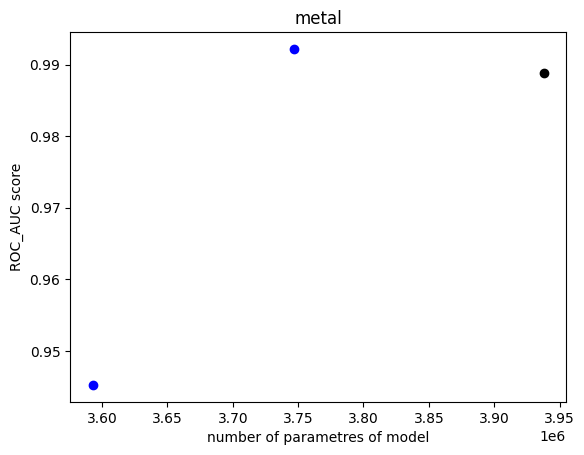

In [31]:
plt.scatter(num_o,auc_1_o,color='black')
plt.scatter(num_1,auc_1_1,color='blue')
plt.scatter(num_2,auc_1_2,color='blue')
plt.xlabel("number of parametres of model")
plt.ylabel("ROC_AUC score")
plt.title("metal")
plt.show()

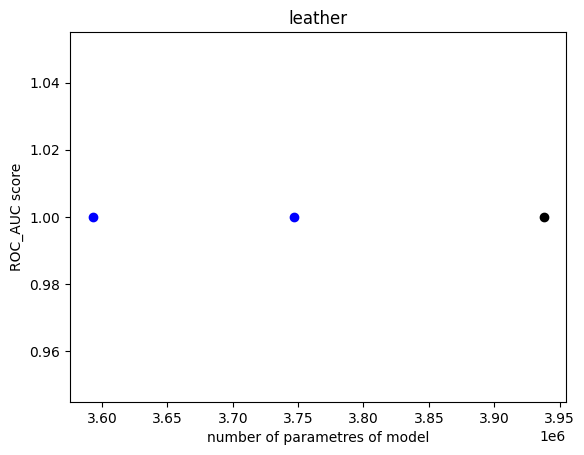

In [32]:
plt.scatter(num_o,auc_2_o,color='black')
plt.scatter(num_1,auc_2_1,color='blue')
plt.scatter(num_2,auc_2_2,color='blue')
plt.xlabel("number of parametres of model")
plt.ylabel("ROC_AUC score")
plt.title("leather")
plt.show()

# 15.Show Testing Results (Input & GT mask & anomaly map) (TODO Q6)

## TODO Q6
In this section, you need to choose a threshold for both class to produce a mask from anomaly map, a pixel with a score higher than the threshold is considered as anomaly region. Threshold should be a number between 0 and 1.

Random choose one inference mask for each class and output results.

(Testing Input / Ground Truth Mask / Predict Mask)

In [33]:
def score_after_threshold(anomaly_score_map,threshold):
  ans = torch.zeros(anomaly_score_map.shape)
  for i in range(len(anomaly_score_map)):
    if anomaly_score_map[i] >= threshold:
      ans[i] = 1
  return ans
mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])

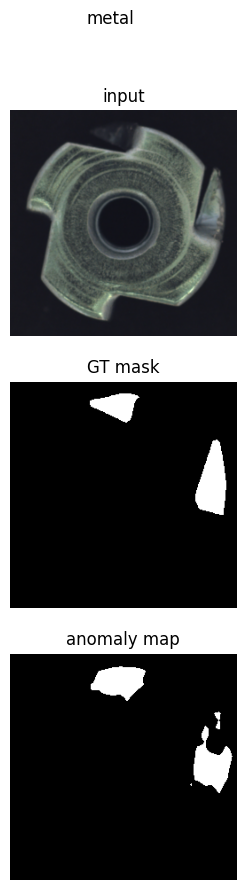

In [49]:
threshold_1 = 0.6
index_1 = 0
for i in range(len(dataset_1_test)):
  if dataset_1_test[i][1] == 1:
    index_1 = i
    break
input_1 = result_1_ori['input_image'][index_1]
input_1 = input_1.transpose(1, 2, 0)
input_1 = input_1*std+mean
gt_1 = result_1_ori['total_gt_pixel'][index_1*65536:(index_1+1)*65536]
gt_1 = gt_1.reshape((256,256))
mask_after_thres_1 = score_after_threshold(result_1_ori['total_scores_pixel'],threshold_1)[index_1*65536:(index_1+1)*65536]
mask_after_thres_1 = mask_after_thres_1.reshape((256,256))
fig, ax=plt.subplots(3,1,figsize=(10,10))
fig.suptitle("metal")
ax[0].axis('off')
ax[0].set_title("input")
ax[0].imshow(input_1, cmap='cividis')
ax[1].axis('off')
ax[1].set_title("GT mask")
ax[1].imshow(gt_1, cmap='gray')
ax[2].axis('off')
ax[2].set_title("anomaly map")
ax[2].imshow(mask_after_thres_1, cmap='gray')

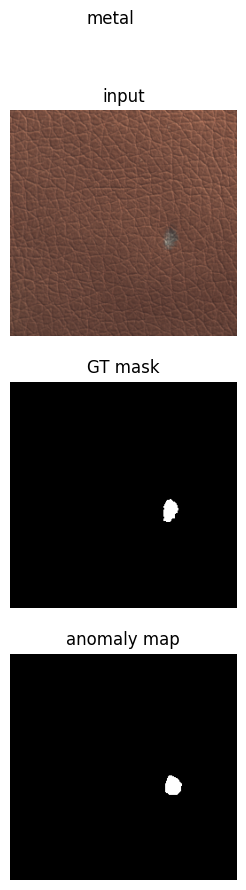

In [35]:
threshold_2 = 0.65
index_2 = 0
for i in range(len(dataset_2_test)):
  if dataset_2_test[i][1] == 1:
    index_2 = i
    break
input_2 = result_2_ori['input_image'][index_2]
input_2 = input_2.transpose(1, 2, 0)
input_2 = input_2*std+mean
gt_2 = result_2_ori['total_gt_pixel'][index_2*65536:(index_2+1)*65536]
gt_2 = gt_2.reshape((256,256))
mask_after_thres_2 = score_after_threshold(result_2_ori['total_scores_pixel'],threshold_2)[index_2*65536:(index_2+1)*65536]
mask_after_thres_2 = mask_after_thres_2.reshape((256,256))
fig, ax=plt.subplots(3,1,figsize=(10,10))
fig.suptitle("metal")
ax[0].axis('off')
ax[0].set_title("input")
ax[0].imshow(input_2, cmap='cividis')
ax[1].axis('off')
ax[1].set_title("GT mask")
ax[1].imshow(gt_2, cmap='gray')
ax[2].axis('off')
ax[2].set_title("anomaly map")
ax[2].imshow(mask_after_thres_2, cmap='gray')

# 16.Ablation Study (TODO Q7 / Q8)

## TODO Q7
In this section, you need to conduct experiment with and without using the `adaptor`, and record the performance respectively

In [36]:
class Simplenet_without_adaptor(nn.Module):
    def __init__(self,in_channel):
        super(Simplenet_without_adaptor,self).__init__()
        self.discriminator = Discriminator(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = rearrange(x,'b c h w -> (b h w) c')
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = rearrange(x,'b c h w -> (b h w) c')
        scores = self.discriminator(true_feats)
        return scores,true_feats

In [37]:
def train_one_epoch_without_adaptor(encoder,simplenet,discriminator_optim,dataset,use_layers,batch_size):
    total_loss = 0
    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        scores = simplenet(features)
        true_scores = scores[:features.size()[0]*features.size()[2]*features.size()[3]]
        fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

        th = 0.5 #margin
        true_loss = torch.clip(true_scores + th, min=0)
        fake_loss = torch.clip(-fake_scores + th, min=0)

        loss = true_loss.mean() + fake_loss.mean()
        total_loss+=loss

        # clear gradient
        discriminator_optim.zero_grad()

        # calculate new gradient
        loss.backward()

        # update parameters
        discriminator_optim.step()
    return total_loss

def train_and_test_without_adaptor(epochs,encoder,SimpleNet,optimizer_d,dataset_train,dataset_test,use_layers,batch_size):
  for i in range(epochs):
    train_one_epoch_without_adaptor(encoder,SimpleNet,optimizer_d,dataset_train,use_layers,batch_size)
  return test(encoder,SimpleNet,dataset_test,use_layers,batch_size)

In [38]:
simple_1_no_adaptor = Simplenet_without_adaptor(1536).cuda()
simple_2_no_adaptor = Simplenet_without_adaptor(1536).cuda()

optimizer_1_no_adaptor_d = torch.optim.AdamW(simple_1_no_adaptor.discriminator.parameters(),discriminator_lr)
optimizer_2_no_adaptor_d = torch.optim.AdamW(simple_2_no_adaptor.discriminator.parameters(),discriminator_lr)

0.9887585532746823


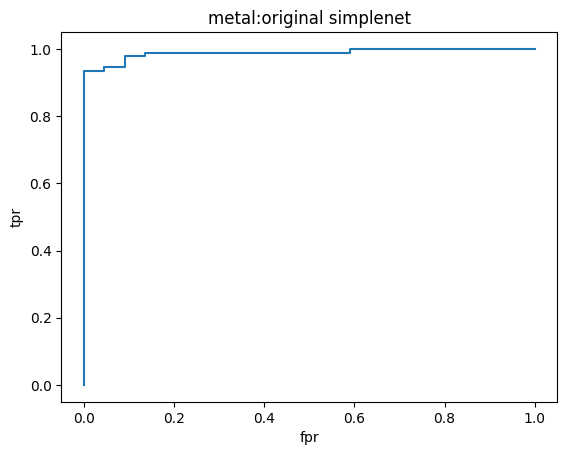

In [39]:
auc_1_o = Calculate_Plot_ROC(result_1_ori['total_scores_image'],result_1_ori['total_gt_image'],"metal","original simplenet")
print(auc_1_o)

0.998533724340176


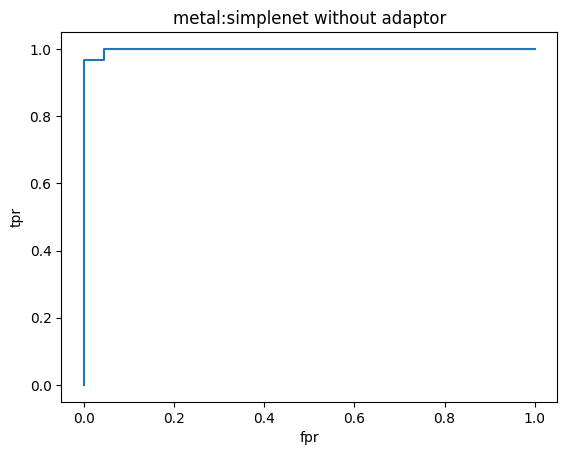

In [40]:
result_1_no_adaptor = train_and_test_without_adaptor(epochs,encoder,simple_1_no_adaptor,optimizer_1_no_adaptor_d,dataset_1_train,dataset_1_test,use_layers,batch_size)
auc_1_no_adaptor = Calculate_Plot_ROC(result_1_no_adaptor['total_scores_image'],result_1_no_adaptor['total_gt_image'],"metal","simplenet without adaptor")
print(auc_1_no_adaptor)
del result_1_no_adaptor
del optimizer_1_no_adaptor_d
del simple_1_no_adaptor

1.0


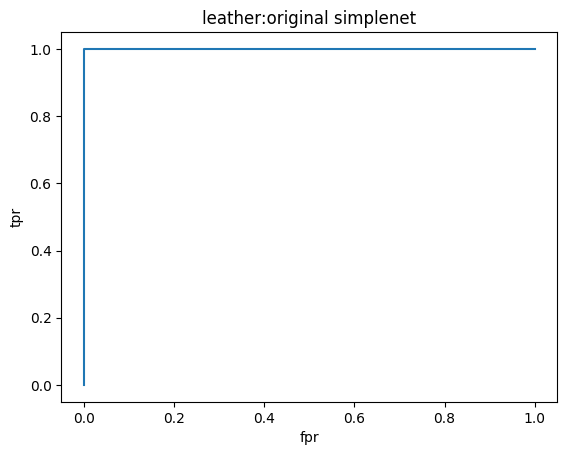

In [41]:
auc_2_o = Calculate_Plot_ROC(result_2_ori['total_scores_image'],result_2_ori['total_gt_image'],"leather","original simplenet")
print(auc_2_o)

1.0


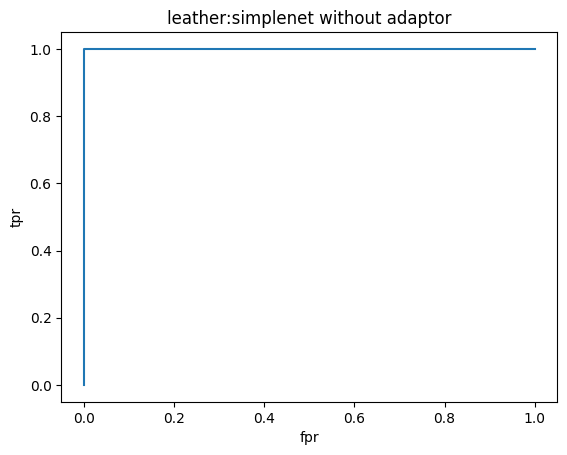

In [42]:
result_2_no_adaptor = train_and_test_without_adaptor(epochs,encoder,simple_2_no_adaptor,optimizer_2_no_adaptor_d,dataset_2_train,dataset_2_test,use_layers,batch_size)
auc_2_no_adaptor = Calculate_Plot_ROC(result_2_no_adaptor['total_scores_image'],result_2_no_adaptor['total_gt_image'],"leather","simplenet without adaptor")
print(auc_2_no_adaptor)
del result_2_no_adaptor
del optimizer_2_no_adaptor_d
del simple_2_no_adaptor

有無adaptor影響不大

## TODO Q8
In this section, you need to conduct experiment with `different scales of the Gaussian noises`. Find the best scale of the noise according to the AUROC performance.

In [43]:
#######################################
# define our model (simplenet)
class Simplenet_diff_scale(nn.Module):
    def __init__(self,in_channel,scale):
        super(Simplenet_diff_scale,self).__init__()
        self.adaptor = Adaptor(in_channel,in_channel)
        self.discriminator = Discriminator(in_channel)
        self.scale = scale

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise * self.scale

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

In [44]:
scale_arr = [0.25,0.5,1,1.5,2]
score_1_arr = []
score_2_arr = []
for scale in scale_arr:
  simple_1_diff_scale = Simplenet_diff_scale(1536,scale).cuda()
  simple_2_diff_scale = Simplenet_diff_scale(1536,scale).cuda()
  optimizer_1_diff_scale_a = torch.optim.AdamW(simple_1_diff_scale.adaptor.parameters(),adaptor_lr)
  optimizer_1_diff_scale_d = torch.optim.AdamW(simple_1_diff_scale.discriminator.parameters(),discriminator_lr)
  optimizer_2_diff_scale_a = torch.optim.AdamW(simple_2_diff_scale.adaptor.parameters(),adaptor_lr)
  optimizer_2_diff_scale_d = torch.optim.AdamW(simple_2_diff_scale.discriminator.parameters(),discriminator_lr)

  result_1 = train_and_test(epochs,encoder,simple_1_diff_scale,optimizer_1_diff_scale_a,optimizer_1_diff_scale_d,dataset_1_train,dataset_1_test,use_layers,batch_size)
  _,_,auc_1_diff_scale = calculate(result_1['total_scores_image'],result_1['total_gt_image'])
  score_1_arr.append(auc_1_diff_scale)
  del result_1
  del optimizer_1_diff_scale_a
  del optimizer_1_diff_scale_d
  del simple_1_diff_scale

  result_2 = train_and_test(epochs,encoder,simple_2_diff_scale,optimizer_2_diff_scale_a,optimizer_2_diff_scale_d,dataset_2_train,dataset_2_test,use_layers,batch_size)
  _,_,auc_2_diff_scale = calculate(result_2['total_scores_image'],result_2['total_gt_image'])
  score_2_arr.append(auc_2_diff_scale)
  del result_2
  del optimizer_2_diff_scale_a
  del optimizer_2_diff_scale_d
  del simple_2_diff_scale


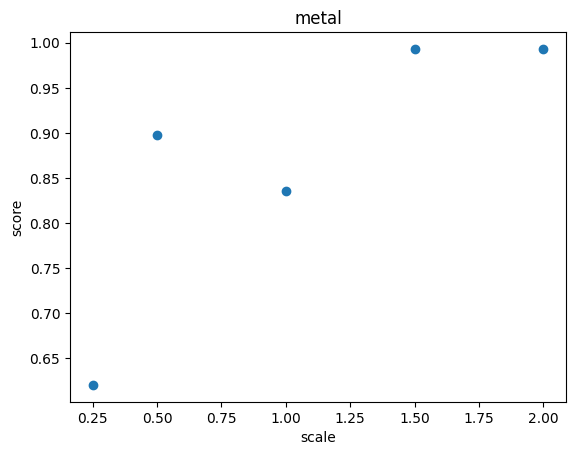

In [45]:
plt.scatter(scale_arr,score_1_arr)
plt.xlabel("scale")
plt.ylabel("score")
plt.title("metal")
plt.show()

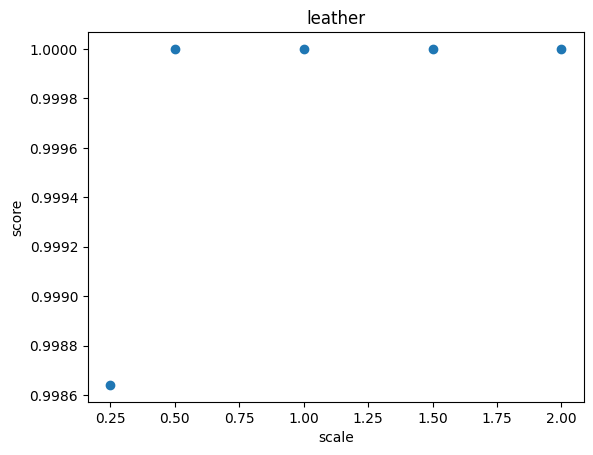

In [46]:
plt.scatter(scale_arr,score_2_arr)
plt.xlabel("scale")
plt.ylabel("score")
plt.title("leather")
plt.show()

best scale: 2

# 17.Report (TODO Q9)

Write your observations on the two classes, for example:</br>
Based on the observation, which class is more difficult and why?

leather分類較簡單，能用較少參數或scale達成較佳效果